In [1]:
(ql:quickload 'kenzo)

To load "kenzo":
  Load 1 ASDF system:
    kenzo

; Loading "kenzo"



(KENZO)

In [2]:
(in-package "CAT")

#<PACKAGE "CAT">

In [3]:
(cat-init)


---done---

NIL

# Chain Complexes

## Introduction

A *chain complex* $(C_p, d_p)$ is a collection of free $\mathbb{Z}$-modules $(C_p)$, one for each
$p \in \mathbb{Z}$, together with a homomorphism $d_p : C_p \rightarrow C_{p-1}$, such
that, for all $p$, $d_{p-1} \circ d_p = 0$. (See, for example, __P.J. Giblin__ in *Graph, Surface and Homology*, Chapman and Hall Math. series, 1981.)

__In the Kenzo program__, a *morphism* $f=(f_p)$, of degree $k$, from a chain complex $(C_p, d_p)$ to another $(C'_p, d'_p)$ is a collection of homomorphisms

$$f_p : C_p \rightarrow C'_{p+k}.$$

This is expressed by the following diagram, generally __not assumend commutative__.

$$
\begin{aligned}
\cdots & \leftarrow & C_{p-1} & \quad\xleftarrow{d_p} & C_p & \quad\xleftarrow{d_{p+1}} & C_{p+1}  & \quad\leftarrow & \cdots \\
       &    & f_{p-1} \Bigg\downarrow &    & f_p \Bigg\downarrow &    & f_{p+1} \Bigg\downarrow \\
\cdots & \leftarrow & C'_{p+k-1} & \quad\xleftarrow{d'_{p+k}} & C'_{p+k} & \quad\xleftarrow{d'_{p+k+1}} & C'_{p+k+1} & \quad\leftarrow & \cdots \end{aligned}
$$

Three types of   morphisms are most generally considered.

1. $k=0$. If the commutativity relation $d'_p\circ f_p=f_{p-1}\circ d_p$ holds for every $p$, then the morphism $f$ is an ordinary chain complex morphism or *chain map*.
2. $k=-1$. If $(C_p,d_p)=(C'_p,d'_p)$ and $f_p=d_p$, then $f$ is the *differential* of the chain complex $(C_p,d_p)$ and, in fact, this differential is implemented in the ${\tt Kenzo}$ program as a morphism of degree $-1$.
3. $k=+1$. In this case, $f$ is usually a *homotopy operator*, that is, some relation $$d'_{p+1}\circ f_p+f_{p-1}\circ d_p=g_p-g'_p$$ is satisfied for two (ordinary) chain complex morphisms $g$ and $g'$.

For technical reasons, these three types of morphisms have been implemented in the $\texttt{Kenzo}$ program
in a unique type.


## Generators, terms, and combinations

To become familiar with the Lisp functions implementing the chain complexes, the best is to begin with an example. *Simplicial complexes* are good candidates for this purpose, and we shall take as a typical example the following simplicial complex.

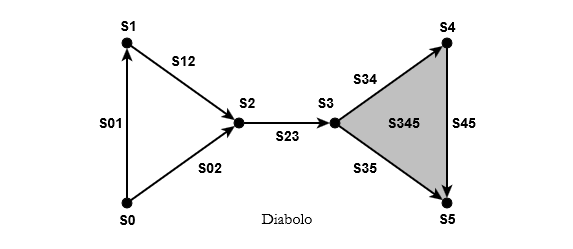

In [4]:
(cl-jupyter-user:png-from-file "diabolo.png")

In this simplicial complex, called here *diabolo*, there are 3 associated chain groups.

* $C_0$, the free $\mathbb{Z}$-module on the set of vertices $\{s_0,s_1,s_2,s_3,s_4,s_5\}$
* $C_1$, the free $\mathbb{Z}$-module on the set of edges $\{s_{01},s_{02},s_{12},s_{23},s_{34},s_{35}, s_{45}\}$
* $C_2$, the free $\mathbb{Z}$-module on the set of triangles (here a singleton) $\{s_{345}\}$

The elements of either of those groups $C_p$ are linear integer combinations of the corresponding basis (set of $\sigma_i$'s), i.e., elements of the form
$$\sum\lambda_i\sigma_i, \quad \lambda_i\in\mathbb{Z}.$$
An element $\sigma_i$ of any basis is also called a *generator* and in our specific case this generator will be represented by a Lisp symbol. For instance, $s_{45}$ will be translated into $\texttt{s45}$. However, the user should be aware that in more realistic usage of the software, generators may be of any type. A product such as $\lambda_i\sigma_i$ is called a *term* and a sum of terms, a *combination*.

### Representation of a combination

A combination is represented internally in the system by a structure having the following general form:
$$\#\texttt{S(CMBN}\quad\texttt{DEGREE P}\quad\texttt{LIST (}\texttt{(}\lambda_1\cdot\sigma_1\texttt{)}\dots\texttt{(}\lambda_k\cdot\sigma_k\texttt{)))}$$
and containing

1. The degree of the combination corresponding to the index $p\in\mathbb{Z}$ of the group $C_p$ to which this combination belongs.
2. The list of the internal representation of the terms, namely the list of pairs $(\lambda_i\cdot\sigma_i)$.

This choice of representation implaies that only homogeneous combinations will be considered. A type $\texttt{CMBN}$ and a printing method are provided with this internal representation. The external form of a combination is shown in the examples.

### Ordering the generators

In order to speed up the execution of algorithms involving combinations, the list of pairs $(\lambda_i.\sigma_i)$ is ordered by an adequate ordering function (ex: the lexicographical ordering n the symbols). For programming convenience, an enumerated type $\texttt{CMPR}$ has been defined:
```lisp
(deftype cmpr() '(member :less :equal :greater))
```
A number of macros, functions and methods have been defined on usual sets (symbols, numbers, lists, etc.) taking their value in the set $\texttt{[:less, :equal, :greater]}$. Of course, the user may define its own function for a particular case.
The functions $\texttt{f-cmpr}$, $\texttt{s-cmpr}$, and $\texttt{l-cmpr}$ can be used to compare various couples of common items.

In [5]:
(documentation 'f-cmpr 'function)

"--------------------------------------------------------------[function-doc]
F-CMPR
Args: (n1 n2)
Returns :LESS, :EQUAL, or :GREATER, according to the result of the canonical
comparison of the integers N1 and N2.
------------------------------------------------------------------------------"

In [6]:
(f-cmpr 123 789)

:LESS

In [7]:
(documentation 's-cmpr 'function)

"--------------------------------------------------------------[function-doc]
S-CMPR
Args: (symbol1 symbol2)
Returns :LESS, :EQUAL, or :GREATER, according to the result of the Lisp string
comparison function of the strings (SYMBOL-NAME SYMBOL1) and
(SYMBOL-NAME SYMBOL2).
------------------------------------------------------------------------------"

In [8]:
(s-cmpr 'circulation 'circular)

:GREATER

In [9]:
(documentation 'l-cmpr 'function)

"--------------------------------------------------------------[function-doc]
L-CMPR
Args: (list1 list2)
Returns :LESS, :EQUAL, or :GREATER, according to the lexicographical ordering
of the generator lists LIST1 and LIST2.
------------------------------------------------------------------------------"

In [10]:
(l-cmpr '(1 a b) '(1 a))

:GREATER

### Functions handling combinations

The software provides a set of functions, methods, and macros to create or modify combinations.

In [11]:
(documentation 'cmbn 'function)

"--------------------------------------------------------------[function-doc]
CMBN
Args: (degr &rest rest)
Returns a combination of degree DEGR from a sum of terms provided as a sequence
CF1 GNRT1 CF2 GNRT2 ... CFn GNRTn of coefficient / generator pairs in REST.
REST can be of arbitrary length including NIL, in which case the combination
is an instance of the null combination of degree DEGR.
------------------------------------------------------------------------------"

In [12]:
(def comb1 (cmbn 1 1 'u 2 'v 3 'w 4 'z))


----------------------------------------------------------------------{CMBN 1}
<1 * U>
<2 * V>
<3 * W>
<4 * Z>
------------------------------------------------------------------------------


In [13]:
(documentation 'cmbn-non-zero-p 'function)

"-----------------------------------------------------------------[macro-doc]
CMBN-NON-ZERO-P
Args: (cmbn)
Tests if the combination CMBN is a non-null combination of any degree.
------------------------------------------------------------------------------"

In [14]:
(cmbn-non-zero-p comb1)

T

The reader function $\texttt{cat:cmbn-list}$ gets the list of terms of the combination $\texttt{cmbn}$. Beware: a term is not a Kenzo object.

In [15]:
(cmbn-list comb1)

((1 . U) (2 . V) (3 . W) (4 . Z))

In [16]:
(def term3 (third (cmbn-list comb1)))

(3 . W)

In [17]:
(documentation 'cffc 'function)

"-----------------------------------------------------------------[macro-doc]
CFFC
Args: (term)
Returns the the coefficient (integer) of a term.
------------------------------------------------------------------------------"

In [18]:
(cffc term3)

3

In [19]:
(documentation 'gnrt 'function)

"-----------------------------------------------------------------[macro-doc]
GNRT
Args: (term)
Returns the the generator of a term.
------------------------------------------------------------------------------"

In [20]:
(gnrt term3)

W

In [21]:
(documentation 'cmbn-opps 'function)

"--------------------------------------------------------------[function-doc]
CMBN-OPPS
Args: (cmbn)
Returns the combination opposite combination of CMBN.
------------------------------------------------------------------------------"

In [22]:
(def mcomb1 (cmbn-opps comb1))


----------------------------------------------------------------------{CMBN 1}
<-1 * U>
<-2 * V>
<-3 * W>
<-4 * Z>
------------------------------------------------------------------------------


In [23]:
(documentation 'n-cmbn 'function)

"--------------------------------------------------------------[function-doc]
N-CMBN
Args: (n cmbn)
Returns N times the combination CMBN. N must be non-zero.
------------------------------------------------------------------------------"

In [24]:
(def comb2 (n-cmbn 10 comb1))


----------------------------------------------------------------------{CMBN 1}
<10 * U>
<20 * V>
<30 * W>
<40 * Z>
------------------------------------------------------------------------------


In [25]:
(documentation '2cmbn-add 'function)

"--------------------------------------------------------------[function-doc]
2CMBN-ADD
Args: (cmpr cmbn1 cmbn2)
Returns the combination, which is the sum of CMBN1 and CMBN2. The first
argument, CMPR, must be a function or macro, which is used to compare the
generators of the combination arguments and to order the terms of the result
combination.
------------------------------------------------------------------------------"

In [26]:
(def cmb12 (2cmbn-add #'s-cmpr comb1 comb2))


----------------------------------------------------------------------{CMBN 1}
<11 * U>
<22 * V>
<33 * W>
<44 * Z>
------------------------------------------------------------------------------


In [27]:
(documentation '2cmbn-sbtr 'function)

"--------------------------------------------------------------[function-doc]
2CMBN-SBTR
Args: (cmpr cmbn1 cmbn2)
Returns the combination, which is the difference of CMBN1 and CMBN2. The first
argument, CMPR, must be a function or macro, which is used to compare the
generators of the combination arguments and to order the terms of the result
combination.
------------------------------------------------------------------------------"

In [28]:
(documentation 'ncmbn-add 'function)

"--------------------------------------------------------------[function-doc]
NCMBN-ADD
Args: (cmpr cmbn &rest rest)
Returns the sum of an arbitrary number of combinations. The first argument,
CMPR, must be a function or macro, which is used to compare the generators of
the input combinations and to order the terms of the result combination.
------------------------------------------------------------------------------"

In [29]:
(ncmbn-add #'s-cmpr
           comb1 comb2 comb1 comb2 comb1 comb2 comb1 comb2 comb1 comb2)


----------------------------------------------------------------------{CMBN 1}
<55 * U>
<110 * V>
<165 * W>
<220 * Z>
------------------------------------------------------------------------------


## Representation of a chain complex

### The function build-chcm

#### A first example of a chain complex

In [30]:
(def diabolo-cmpr #'s-cmpr)

#<FUNCTION S-CMPR>

In [31]:
(def diabolo-basis #'(lambda (dmn)
                             (case dmn
                                 (0 '(s0 s1 s2 s3 s4 s5))
                                 (1 '(s01 s02 s12 s23 s34 s35 s45))
                                 (2 '(s345))
                                 (otherwise nil))))

#<FUNCTION (LAMBDA (DMN) :IN "/home/gerd/git/cl-jupyter/cl-jupyter.lisp") {1006EEE2CB}>

In [32]:
(def diabolo-bspn 's0)

S0

In [33]:
(def diabolo-pure-dffr
         #'(lambda (dmn gnr)
                   (unless (<= 0 dmn 2)
                       (error "Incorrect dimension for diabolo-dp."))
                   (case dmn
                       (0 (cmbn -1))  ; Note the null combination of degree -1
                       (1 (case gnr
                              (s01 (cmbn 0 -1 's0 1 's1))
                              (s02 (cmbn 0 -1 's0 1 's2))
                              (s12 (cmbn 0 -1 's1 1 's2))
                              (s23 (cmbn 0 -1 's2 1 's3))
                              (s34 (cmbn 0 -1 's3 1 's4))
                              (s35 (cmbn 0 -1 's3 1 's5))
                              (s45 (cmbn 0 -1 's4 1 's5))))
                       (2 (case gnr
                              (s345 (cmbn 1 1 's34 -1 's35 1 's45))))
                       (otherwise (error "Bad generator for complex diabolo")))))

#<FUNCTION (LAMBDA (DMN GNR) :IN "/home/gerd/git/cl-jupyter/cl-jupyter.lisp") {10070DAB5B}>

In [34]:
(def diabolo-strt :GNRT)

:GNRT

In [35]:
(def diabolo-orgn '(diabolo-for-example))

(DIABOLO-FOR-EXAMPLE)

In [36]:
(documentation 'build-chcm 'function)

"--------------------------------------------------------------[function-doc]
BUILD-CHCM
Args: (&key cmpr basis bsgn intr-dffr strt orgn)
Returns an instance of the class CHAIN-COMPLEX. The keyword arguments are as
follows:

:CMPR CMPR, the comparison function for generators

:BASIS BASIS, the function defining the basis of the freee Z-modules C_p or the
              the keyword :LOCALLY-EFFECTIVE

:BSGN BSGN, a generator, the base point of the underlying set

:INTR-DFFR INTR-DFFR, a Lisp function defining the differential homomorphism
                      for each p (d_p: C_p -> C_{p-1}

:STRT STRT, one of the keywords :GNRT or :CMBN, defining the mapping strategy
            of the differential homomorphism, either by generator or by
            combination. The default is :GNRT

:ORGN ORGN, a list which is the copy of a Lisp statement, in principle the
            statement which was at the origin of the creation of this Kenzo
            object. A caching process, using this slot

In [37]:
(def diabolo (build-chcm :cmpr diabolo-cmpr :basis diabolo-basis
                         :bsgn diabolo-bspn :intr-dffr diabolo-pure-dffr
                         :strt diabolo-strt :orgn diabolo-orgn))

[K1 Chain-Complex]

In [38]:
(documentation 'chcm 'function)

"--------------------------------------------------------------[function-doc]
CHCM
Args: (idnm)
Return from the list *CHCM-LIST* the chain complex instance with Kenzo
identifier IDNUM or NIL, if it doesn't exist.
------------------------------------------------------------------------------"

In [39]:
(chcm 1)

[K1 Chain-Complex]

In [40]:
(orgn diabolo)

(DIABOLO-FOR-EXAMPLE)

In [41]:
(idnm diabolo)

1

In [42]:
(basis diabolo 0)

(S0 S1 S2 S3 S4 S5)

In [43]:
(basis diabolo 1)

(S01 S02 S12 S23 S34 S35 S45)

In [44]:
(basis diabolo 2)

(S345)

In [45]:
(basis diabolo 10)

NIL

In [46]:
(dffr diabolo 2 's345)


----------------------------------------------------------------------{CMBN 1}
<1 * S34>
<-1 * S35>
<1 * S45>
------------------------------------------------------------------------------


In [47]:
(dffr diabolo *)


----------------------------------------------------------------------{CMBN 0}
------------------------------------------------------------------------------


#### An important trivial case: the unit chain complex, $\mathbb{Z}$

In [48]:
(def ZCC
    (the chain-complex
         (build-chcm
          :cmpr #'(lambda (gnrt1 gnrt2)
                          (declare (ignore gnrt1 gnrt2))
                          (the cmpr :equal))
          :basis #'(lambda (n)
                           (the list
                                (if (zerop n) '(:Z-gnrt) +empty-list+)))
          :bsgn :Z-gnrt
          :intr-dffr #'(lambda (cmbn)
                               (the cmbn (zero-cmbn (1- (cmbn-degr cmbn)))))
          :strt :cmbn
          :orgn '(zcc-constant))))

[K3 Chain-Complex]

In [49]:
(documentation 'z-chcm 'function)

"--------------------------------------------------------------[function-doc]
Z-CHCM
Args: ()
Build the unit chain complex.
------------------------------------------------------------------------------"

#### The chain complex $\texttt{circle}$

In [50]:
(defun CIRCLE ()
    (the chain-complex
         (build-chcm
          :cmpr #'(lambda (gnrt1 gnrt2)
                          (declare (ignore gnrt1 gnrt2))
                          (the cmpr :equal))
          :basis #'(lambda (dmns)
                           (the list
                                (case dmns (0 '(*)) (1 '(s1))
                                    (otherwise +empty-list+))))
          :bsgn '*
          :intr-dffr #'zero-intr-dffr
          :strt :cmbn
          :orgn '(circle))))

REDEFINITION-WITH-DEFUN: 
  #<SB-KERNEL:REDEFINITION-WITH-DEFUN {10047995D3}>


CIRCLE

## Morphisms

In [51]:
(documentation 'morphism 'type)

"----------------------------------------------------------------[class-doc]
MORPHISM
Slots: (sorc trgt degr intr strt ???-clnm ?-clnm rslts idnm orgn)
Intances of this class represent morphisms between chain complexes, and the
differential homomorphism of a chain complex is treated as a morphism of
degree -1. The class has 10 slots:

1. SORC, an object of type CHAIN-COMPLEX, the source chain complex of this
   morphism. Its reader function is SORC.

2. TRGT, an object of type CHAIN-COMPLEX, the target chain complex of this
   morphism. Its reader function is TRGT.

3. DEGR, an integer, the degree of the morphism. Its reader function is DEGR.

4. INTR, a Lisp INTeRnal function implementing the morphism, taking account
   of the strategy STRT. Its reader function is INTR.

5. STRT, a symbol, one of :GNRT or :CMBN. Its reader function is STRT.

   If this slot is :GNRT, the implementation of INTR is a function:
     (function (degr gnrt) cmbn)
   and for any call of this function, the re

### The function $\texttt{build-mprh}$

In [52]:
(documentation 'build-mrph 'function)

"--------------------------------------------------------------[function-doc]
BUILD-MRPH
Args: (&key sorc trgt degr intr strt orgn)
Returns an instance of the class MORPHISM. The keyword arguments are as
follows:

:SORC SORC, the source object, a CHAIN-COMPLEX type object

:TRGT TRGT, the target object, a CHAIN-COMPLEX type object

:DEGR DEGR, the degree of the morphism, an integer

:INTR INTR, the Lisp function defining the effective mapping

:STRT STRT, one of the keywords :GNRT or :CMBN, defining the mapping strategy
            of the differential homomorphism, either by generator or by
            combination. The default is :GNRT

:ORGN ORGN, a list which is the copy of a Lisp statement, in principle the
            statement which was at the origin of the creation of this Kenzo
            object. A caching process, using this slot, prevents the creation
            of multiple copies of the same mathematical object, which is
            important for efficiency. It is used also

#### The differential homomorphism in a chain complex instance

In [53]:
(cat-init)


---done---

NIL

In [54]:
(def ZCC (z-chcm))

[K1 Chain-Complex]

In [55]:
(def zero-morphism (build-mrph :sorc ZCC
                               :trgt ZCC
                               :degr -1
                               :intr #'(lambda (comb)
                                               (cmbn (1- (degr comb))))
                               :strt :cmbn
                               :orgn '(zero morphism on ZCC)))

[K3 Cohomology-Class on K1 of degree 1]

In [56]:
(def id-morphism (build-mrph :sorc ZCC
                             :trgt ZCC
                             :degr 0
                             :intr #'identity
                             :strt :cmbn
                             :orgn '(identity morphism on ZCC)))

[K4 Cohomology-Class on K1 of degree 0]

### Applying morphisms

### Functions defining morphisms

In [57]:
(def ccn-boundary #'(lambda (dgr gnr)
                            (if (evenp (+ dgr gnr))
                                (cmbn (1- dgr) 1 (- gnr 10))
                                (cmbn (1- dgr)))))

#<FUNCTION (LAMBDA (DGR GNR) :IN "/home/gerd/git/cl-jupyter/cl-jupyter.lisp") {1004B84A7B}>

In [58]:
(def ccn (build-chcm :cmpr #'f-cmpr
                     :basis #'(lambda (n) (<a-b< (* 10 n) (* 10 (1+ n))))
                     :bsgn 0
                     :intr-dffr ccn-boundary
                     :strt :gnrt
                     :orgn '(ccn)))

[K5 Chain-Complex]

In [59]:
(def upper-shift (build-mrph
                  :sorc ccn :trgt ccn :strt :gnrt :degr +1
                  :intr #'(lambda (d gn) (cmbn (1+ d) 1 (+ gn 10)))
                  :orgn '(ccn shift +10)))

[K7 Morphism (degree 1): K5 -> K5]

In [60]:
(def lower-shift (build-mrph
                  :sorc ccn :trgt ccn :strt :gnrt :degr -1
                  :intr #'(lambda (d gn) (cmbn (1- d) 1 (- gn 10)))
                  :orgn '(ccn shift -10)))

[K8 Morphism (degree -1): K5 -> K5]

In [61]:
(? ccn 2 22)


----------------------------------------------------------------------{CMBN 1}
<1 * 12>
------------------------------------------------------------------------------


In [62]:
(? ccn *)


----------------------------------------------------------------------{CMBN 0}
------------------------------------------------------------------------------


In [63]:
(def combn (cmbn 5 1 50 5 55 9 59))


----------------------------------------------------------------------{CMBN 5}
<1 * 50>
<5 * 55>
<9 * 59>
------------------------------------------------------------------------------


In [64]:
(? ccn combn)


----------------------------------------------------------------------{CMBN 4}
<5 * 45>
<9 * 49>
------------------------------------------------------------------------------


In [65]:
(? ccn *)


----------------------------------------------------------------------{CMBN 3}
------------------------------------------------------------------------------


In [66]:
(? upper-shift 0 6)


----------------------------------------------------------------------{CMBN 1}
<1 * 16>
------------------------------------------------------------------------------


In [67]:
(? lower-shift 5 51)


----------------------------------------------------------------------{CMBN 4}
<1 * 41>
------------------------------------------------------------------------------


In [68]:
(? lower-shift (? lower-shift 5 51))


----------------------------------------------------------------------{CMBN 3}
<1 * 31>
------------------------------------------------------------------------------


In [69]:
(def comb1 (cmbn 1 1 10 2 11 3 12 4 13))


----------------------------------------------------------------------{CMBN 1}
<1 * 10>
<2 * 11>
<3 * 12>
<4 * 13>
------------------------------------------------------------------------------


In [70]:
(def identity? (cmps upper-shift lower-shift))

[K9 Morphism (degree 0): K5 -> K5]

In [71]:
(degr identity?)

0

In [72]:
(? identity? comb1)


----------------------------------------------------------------------{CMBN 1}
<1 * 10>
<2 * 11>
<3 * 12>
<4 * 13>
------------------------------------------------------------------------------


In [73]:
(2cmbn-sbtr (cmpr ccn) comb1 *)


----------------------------------------------------------------------{CMBN 1}
------------------------------------------------------------------------------


In [74]:
(def upper-shift2 (cmps upper-shift upper-shift))

[K10 Morphism (degree 2): K5 -> K5]

In [75]:
(degr upper-shift2)

2

In [76]:
(? upper-shift2 comb1)


----------------------------------------------------------------------{CMBN 3}
<1 * 30>
<2 * 31>
<3 * 32>
<4 * 33>
------------------------------------------------------------------------------


In [77]:
(def twice-up-shift (add upper-shift upper-shift))

[K11 Morphism (degree 1): K5 -> K5]

In [78]:
(degr twice-up-shift)

1

In [79]:
(? twice-up-shift comb1)


----------------------------------------------------------------------{CMBN 2}
<2 * 20>
<4 * 21>
<6 * 22>
<8 * 23>
------------------------------------------------------------------------------


In [80]:
(def up-d (cmps upper-shift (dffr1 ccn)))

[K12 Morphism (degree 0): K5 -> K5]

In [81]:
(def d-up (cmps (dffr1 ccn) upper-shift))

[K13 Morphism (degree 0): K5 -> K5]

In [82]:
(? up-d 1 11)


----------------------------------------------------------------------{CMBN 1}
<1 * 11>
------------------------------------------------------------------------------


In [83]:
(? d-up 1 11)


----------------------------------------------------------------------{CMBN 1}
------------------------------------------------------------------------------


In [84]:
(def comb3 (cmbn 1 1 10 2 11 3 12 4 13 5 14 6 15))


----------------------------------------------------------------------{CMBN 1}
<1 * 10>
<2 * 11>
<3 * 12>
<4 * 13>
<5 * 14>
<6 * 15>
------------------------------------------------------------------------------


In [85]:
(? up-d comb3)


----------------------------------------------------------------------{CMBN 1}
<2 * 11>
<4 * 13>
<6 * 15>
------------------------------------------------------------------------------


In [86]:
(? d-up comb3)


----------------------------------------------------------------------{CMBN 1}
<1 * 10>
<3 * 12>
<5 * 14>
------------------------------------------------------------------------------


### Accessing $\texttt{Kenzo}$ objects

In [87]:
(k 1)

[K1 Chain-Complex]

In [88]:
(kd 1)


Object: [K1 Chain-Complex]
  Origin: (Z-CHCM)



NIL

In [89]:
(k 3)

[K3 Cohomology-Class on K1 of degree 1]

In [90]:
(kd 3)


Object: [K3 Cohomology-Class on K1 of degree 1]
  Origin: (ZERO MORPHISM ON ZCC)



NIL

In [91]:
(kd 8)


Object: [K8 Morphism (degree -1): K5 -> K5]
  Origin: (CCN SHIFT -10)



NIL

In [92]:
(kd 5)


Object: [K5 Chain-Complex]
  Origin: (CCN)



NIL

In [93]:
(kd 9)


Object: [K9 Morphism (degree 0): K5 -> K5]
  Origin: (2MRPH-CMPS [K7 Morphism (degree 1): K5 -> K5] [K8 Morphism (degree -1): K5 -> K5] GNRT)



NIL

In [94]:
(kd2 9)


Object: [K9 Morphism (degree 0): K5 -> K5]
  Origin: (2MRPH-CMPS [K7 Morphism (degree 1): K5 -> K5] [K8 Morphism (degree -1): K5 -> K5] GNRT)


Object: [K8 Morphism (degree -1): K5 -> K5]
  Origin: (CCN SHIFT -10)


Object: [K7 Morphism (degree 1): K5 -> K5]
  Origin: (CCN SHIFT 10)



(9 8 7)